# Przewidywanie Intencji Zakupowych 

## CEL: Klasyfikacja binarna przewidująca, czy użytkownik dokona zakupu (kolumna `Revenue`) na podstawie danych o zachowaniu na stronie e-commerce.


## 1. Import bibliotek


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

from tabulate import tabulate # Do wypisania statystyk opisowych w przejrzystej formie

# Import klas z ml_classes.py
from ml_classes import DataLoader, DataPreprocessor, DataAnalyzer, FeatureEngineer, ModelTrainer, HyperparameterTuner, check_and_handle_imbalance

# Konfiguracja wizualizacji
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline


## 2. Konfiguracja Projektu

In [2]:
# Konfiguracja projektu
CONFIG = {
    'data_path': 'online_shoppers_intention.csv',
    'target_col': 'Revenue',
    'test_size': 0.2,
    'random_state': 42
}

## 3. Pobranie Danych


In [3]:
# Inicjalizacja DataLoader
loader = DataLoader()

# Wczytanie danych
data = loader.load_data(CONFIG['data_path'])

# Podstawowe informacje o zbiorze
info = loader.get_info()

print(f"\nUżycie pamięci: {info['memory_usage'] / 1024**2:.2f} MB")

print(f"\nBrakujące wartości:")
missing = {k: v for k, v in info['missing_values'].items() if v > 0}
if missing:
    for col, count in missing.items():
        print(f"  - {col}: {count}")
else:
    print("Brak")

# Podgląd danych
print("\nPierwsze 5 wierszy")
data.head()


Dane wczytane pomyślnie z: online_shoppers_intention.csv
Kształt danych: (12330, 18)

Użycie pamięci: 2.72 MB

Brakujące wartości:
Brak

Pierwsze 5 wierszy


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


## 4. Wstęny Preprocessing Danych

In [4]:
# Inicjalizacja preprocessora
preprocessor = DataPreprocessor()

# Pelny pipeline preprocessingu
X, y = preprocessor.preprocess_pipeline(
    data, 
    target_col='Revenue',
    normalize=False,
    fit=True
)

print(f"Kształt X: {X.shape}")
print(f"Kształt y: {y.shape}")
print(f"\nRozkład klas docelowych:")
print(y.value_counts())
print(f"\nProcentowy rozkład:")
print(y.value_counts(normalize=True) * 100)


Kształt X: (12330, 17)
Kształt y: (12330,)

Rozkład klas docelowych:
Revenue
False    10422
True      1908
Name: count, dtype: int64

Procentowy rozkład:
Revenue
False    84.525547
True     15.474453
Name: proportion, dtype: float64


## 5. Analiza Danych

In [5]:
# Inicjalizacja analizatora
analyzer = DataAnalyzer()

# Statystyki opisowe
stats = analyzer.descriptive_statistics(data.select_dtypes(include=[np.number]))
pretty_stats = stats.T.reset_index().round(2)

# Metadata i jednostki kazdej kolumny
metadata = {
    'Administrative': 'pages',
    'Administrative_Duration': 'sec',
    'Informational': 'pages',
    'Informational_Duration': 'sec',
    'ProductRelated': 'pages',
    'ProductRelated_Duration': 'sec',
    'BounceRates': '%',
    'ExitRates': '%',
    'PageValues': 'value',
    'SpecialDay': '%',
    'OperatingSystems': 'ID',
    'Browser': 'ID',
    'Region': 'ID',
    'TrafficType': 'ID'
}

pretty_stats['Unit'] = pretty_stats['index'].map(metadata).fillna('-')
cols = ['index', 'Unit'] + [col for col in pretty_stats.columns if col not in ['index', 'Unit']]
pretty_stats = pretty_stats[cols]


print("Raport statystyczny:")
print(tabulate(pretty_stats, headers='keys', tablefmt='psql'))


Raport statystyczny:
+----+-------------------------+--------+---------+---------+---------+-------+--------+--------+---------+----------+
|    | index                   | Unit   |   count |    mean |     std |   min |    25% |    50% |     75% |      max |
|----+-------------------------+--------+---------+---------+---------+-------+--------+--------+---------+----------|
|  0 | Administrative          | pages  |   12330 |    2.32 |    3.32 |     0 |   0    |   1    |    4    |    27    |
|  1 | Administrative_Duration | sec    |   12330 |   80.82 |  176.78 |     0 |   0    |   7.5  |   93.26 |  3398.75 |
|  2 | Informational           | pages  |   12330 |    0.5  |    1.27 |     0 |   0    |   0    |    0    |    24    |
|  3 | Informational_Duration  | sec    |   12330 |   34.47 |  140.75 |     0 |   0    |   0    |    0    |  2549.38 |
|  4 | ProductRelated          | pages  |   12330 |   31.73 |   44.48 |     0 |   7    |  18    |   38    |   705    |
|  5 | ProductRelated_Durat

In [6]:
# Analiza korelacji z targetem
print("Korelacje ze zmienną docelową (Revenue)")
# DataAnalyzer zakoduje kolumny kategoryczne
correlations = analyzer.correlation_analysis(data, target='Revenue')
print(correlations.sort_values(ascending=False))


=== Korelacje ze zmienną docelową (Revenue) ===
Revenue                    1.000000
PageValues                 0.492569
ProductRelated             0.158538
ProductRelated_Duration    0.152373
Administrative             0.138917
Informational              0.095200
Administrative_Duration    0.093587
Informational_Duration     0.070345
Browser                    0.023984
TrafficType               -0.005113
Region                    -0.011595
OperatingSystems          -0.014668
SpecialDay                -0.082305
BounceRates               -0.150673
ExitRates                 -0.207071
Name: Revenue, dtype: float64


## 6. Wizualizacja Danych Na Wykresach


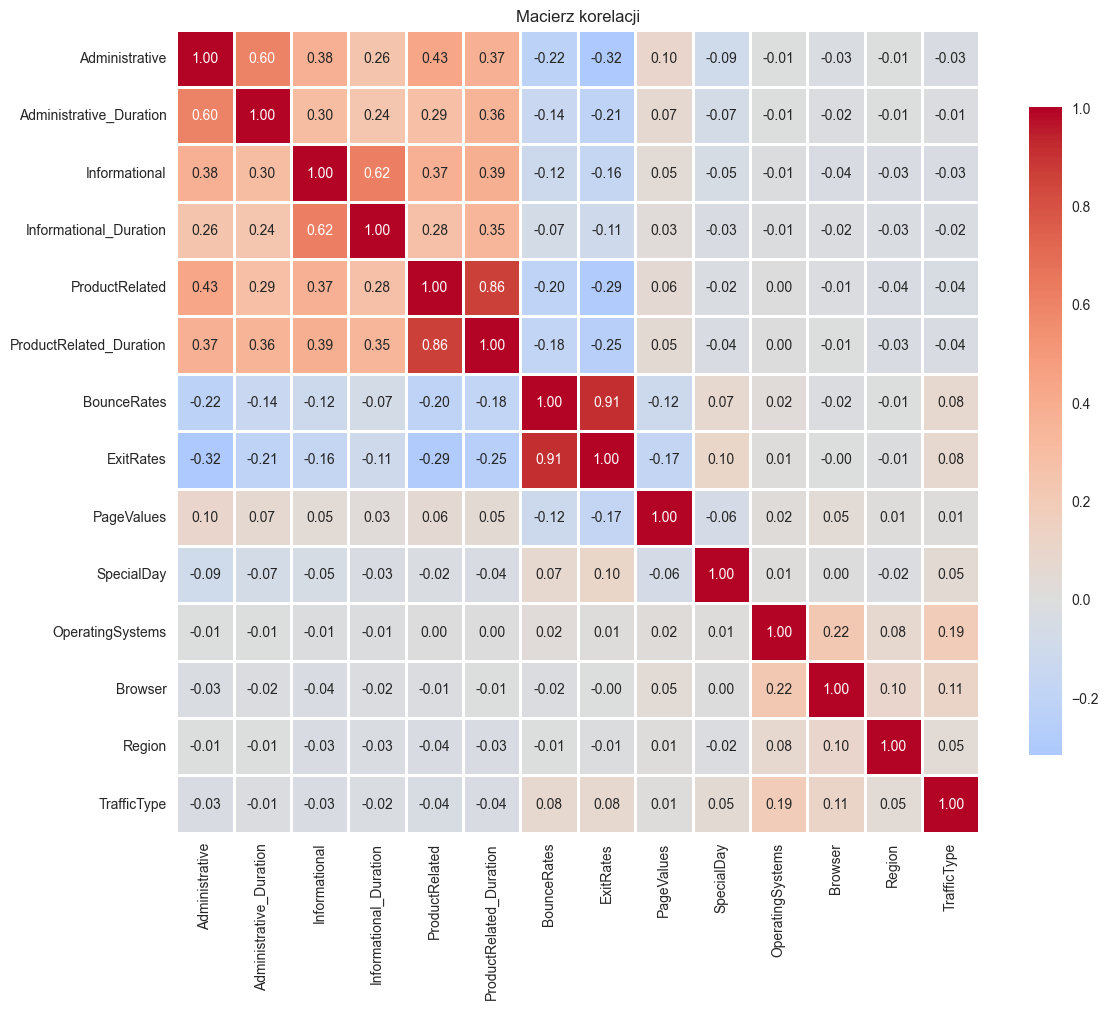

In [7]:
# Wizualizacja macierzy korelacji
analyzer.visualize_correlations(data)


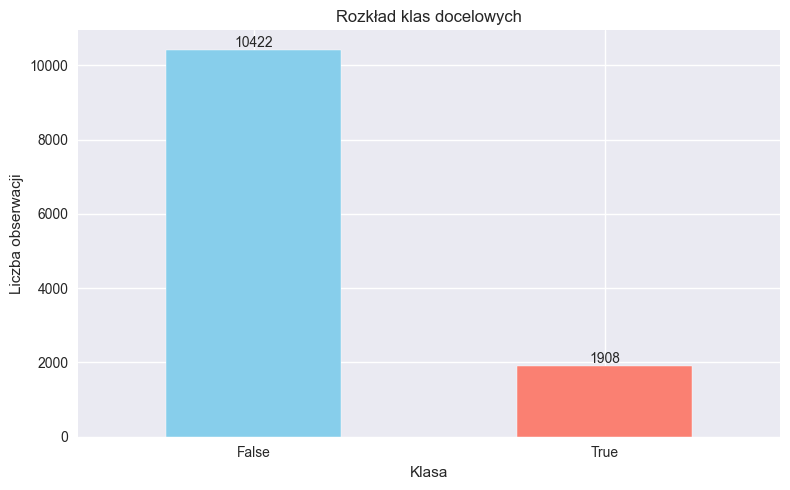


Balans klas: Niezbalansowany


In [8]:
# Analiza balansu klas
balance_info = analyzer.class_balance_analysis(y)
print(f"\nBalans klas: {'Zbalansowany' if balance_info['is_balanced'] else 'Niezbalansowany'}")


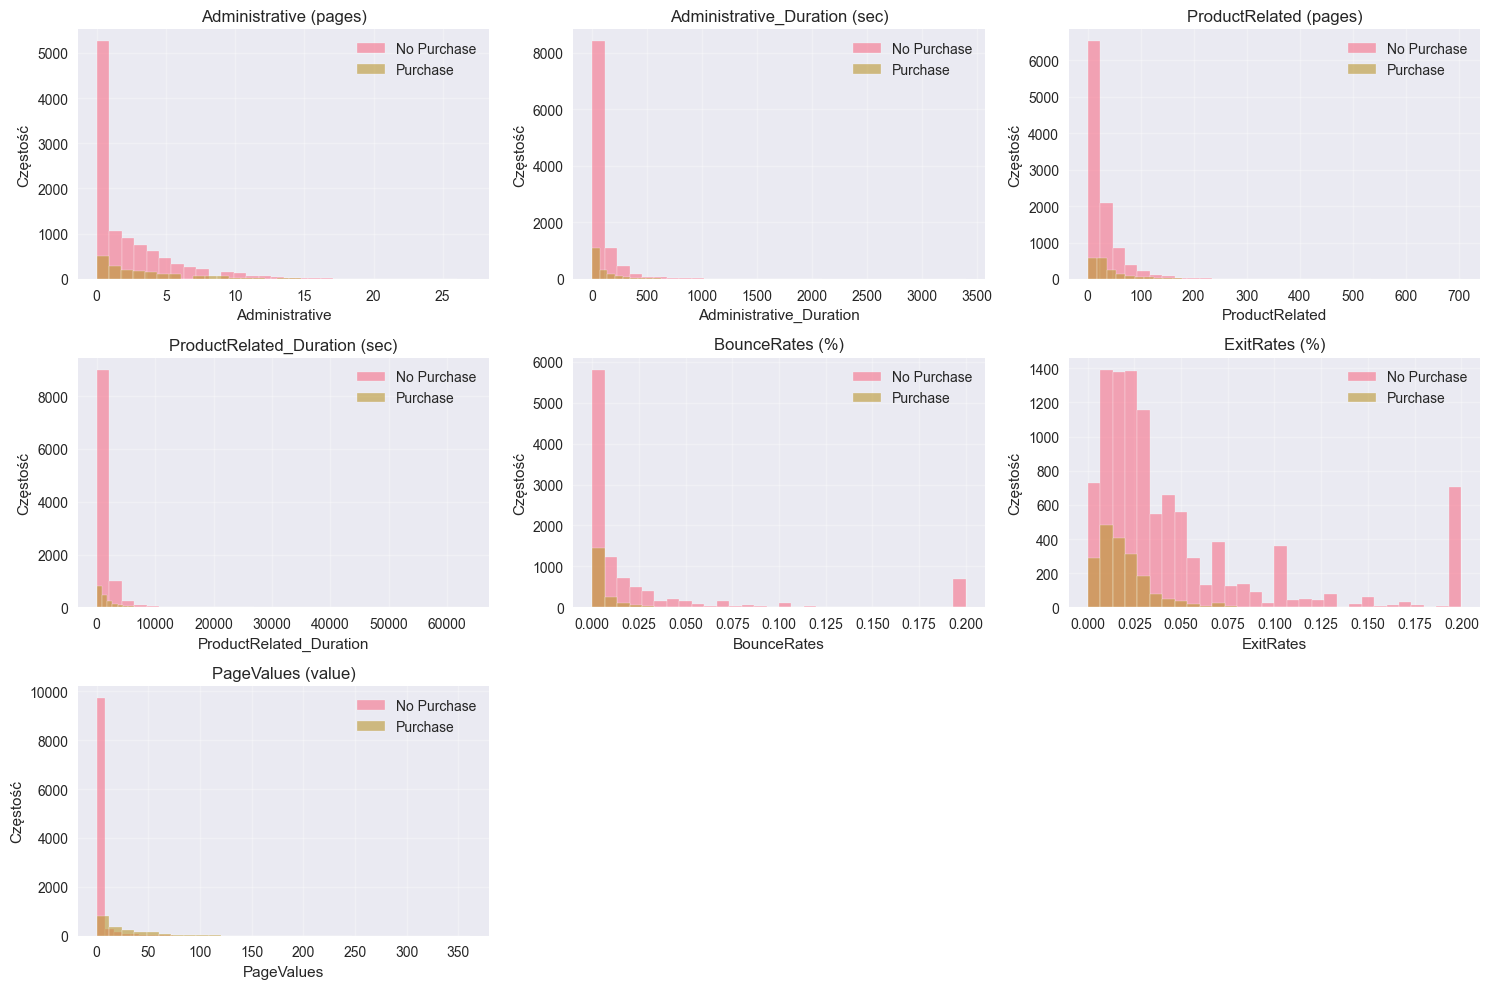

In [9]:
# Wizualizacja rozkładów wybranych zmiennych
numeric_cols = ['Administrative', 'Administrative_Duration', 'ProductRelated', 
                'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues']

# wizualizacja metadata
metadata = {
    'Administrative': 'pages',
    'Administrative_Duration': 'sec',
    'ProductRelated': 'pages',
    'ProductRelated_Duration': 'sec',
    'BounceRates': '%',
    'ExitRates': '%',
    'PageValues': 'value'
}

analyzer.visualize_distributions(data[numeric_cols + ['Revenue']], columns=numeric_cols, metadata=metadata)


## 7. Feature Engineering


In [10]:
# Inicjalizacja feature engineer
feature_engineer = FeatureEngineer()

# Tworzenie nowych cech
X_with_features = feature_engineer.create_interaction_features(X)

print(f"Liczba cech przed feature engineering: {X.shape[1]}")
print(f"Liczba cech po feature engineering: {X_with_features.shape[1]}")
X_selected, selected_features = feature_engineer.select_features(
    X_with_features,
    y,
    method='importance',
    threshold=0.01
)

X_final = X_selected.copy()


Liczba cech przed feature engineering: 17
Liczba cech po feature engineering: 22


Liczba wybranych cech: 19

Wybrane cechy:
  - Administrative
  - Administrative_Duration
  - Informational
  - Informational_Duration
  - ProductRelated
  - ProductRelated_Duration
  - BounceRates
  - ExitRates
  - PageValues
  - Month
  - OperatingSystems
  - Browser
  - Region
  - TrafficType
  - TotalPages
  - TotalDuration
  - AvgPageDuration
  - BounceExitRatio
  - ProductRelatedRatio


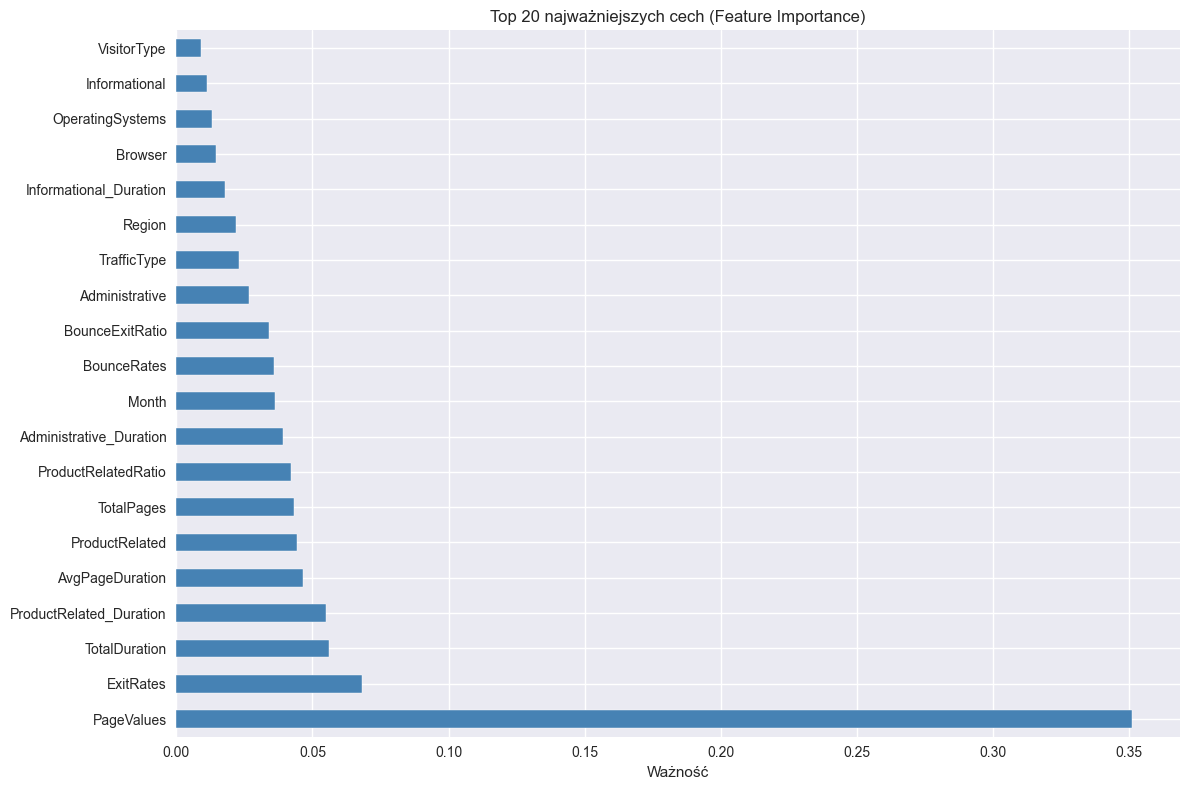

In [11]:
# Selekcja zmiennych na podstawie waznosci (Random Forest)
X_selected, selected_features = feature_engineer.select_features(
    X_with_features, 
    y,
    method='importance', 
    threshold=0.01
)

print(f"Liczba wybranych cech: {len(selected_features)}")
print(f"\nWybrane cechy:")
for feat in selected_features:
    print(f"  - {feat}")

# Wizualizacja waznosci cech
if feature_engineer.feature_importance is not None:
    plt.figure(figsize=(12, 8))
    top_features = feature_engineer.feature_importance.head(20)
    top_features.plot(kind='barh', color='steelblue')
    plt.title('Top 20 najważniejszych cech (Feature Importance)')
    plt.xlabel('Ważność')
    plt.tight_layout()
    plt.show()


In [12]:
X_final = X_selected.copy() 
print(f"Końcowy kształt danych (przed skalowaniem): {X_final.shape}")
print(f"Liczba obserwacji: {X_final.shape[0]}")
print(f"Liczba cech: {X_final.shape[1]}")

Końcowy kształt danych (przed skalowaniem): (12330, 19)
Liczba obserwacji: 12330
Liczba cech: 19


## 8. Przygotowanie Zbiorów


In [13]:
# Podzial na zbior treningowy i testowy (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_final, 
    y,
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Zbiór treningowy: {X_train.shape[0]} obserwacji")
print(f"Zbiór testowy: {X_test.shape[0]} obserwacji")
print(f"\nRozkład klas w zbiorze treningowym:")
print(y_train.value_counts(normalize=True) * 100)
print(f"\nRozkład klas w zbiorze testowym:")
print(y_test.value_counts(normalize=True) * 100)

Zbiór treningowy: 9864 obserwacji
Zbiór testowy: 2466 obserwacji

Rozkład klas w zbiorze treningowym:
Revenue
False    84.529603
True     15.470397
Name: proportion, dtype: float64

Rozkład klas w zbiorze testowym:
Revenue
False    84.509327
True     15.490673
Name: proportion, dtype: float64


## 9. Trenowanie Modeli


In [14]:
# Inicjalizacja trenera modeli
trainer = ModelTrainer()

# Uzywamy Pipeline dla wszystkich modeli - zapewnia spojnosc i unika wycieku danych
print("\n Przygotowanie danych do trenowania baseline modeli")
print("Uwaga: Używamy Pipeline - skalowanie odbywa się automatycznie")

# Analiza balansu klas
class_counts = Counter(y_train)
print(f"\nRozkład klas w zbiorze treningowym: {class_counts}")
imbalance_ratio = min(class_counts.values()) / max(class_counts.values())
print(f"Współczynnik niezbalansowania: {imbalance_ratio:.2f}")
if imbalance_ratio < 0.8:
    print("Wykryto niezbalansowanie klas - automatycznie zastosujemy class_weight='balanced'")
else:
    print(" Klasy są względnie zbalansowane")

# Trenowanie roznych modeli z automatyczna obsluga niezbalansowania
# Wszystkie modele uzywaja Pipeline ze StandardScaler
models = {}

print("\n Trenowanie Logistic Regression")
lr_base = LogisticRegression(random_state=42, max_iter=1000)
# Sprawdz balans klas i dodaj class_weight jesli potrzebne
imbalance_params = check_and_handle_imbalance(y_train)
if imbalance_params:
    lr_base.set_params(**imbalance_params)
    print(f"Stosowanie parametrów: {imbalance_params}")
lr_pipeline = Pipeline([('scaler', StandardScaler()), ('model', lr_base)])
lr_pipeline.fit(X_train, y_train)
models['Logistic Regression'] = lr_pipeline

print("\n=== Trenowanie Random Forest ===")
rf_base = RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=None)
imbalance_params = check_and_handle_imbalance(y_train)
if imbalance_params:
    rf_base.set_params(**imbalance_params)
    print(f"Stosowanie parametrów: {imbalance_params}")
rf_pipeline = Pipeline([('scaler', StandardScaler()), ('model', rf_base)])
rf_pipeline.fit(X_train, y_train)
models['Random Forest'] = rf_pipeline

print("\n Trenowanie SVM ")
svm_base = SVC(random_state=42, probability=True, kernel='rbf', C=1.0)
imbalance_params = check_and_handle_imbalance(y_train)
if imbalance_params:
    svm_base.set_params(**imbalance_params)
    print(f"Stosowanie parametrów: {imbalance_params}")
svm_pipeline = Pipeline([('scaler', StandardScaler()), ('model', svm_base)])
svm_pipeline.fit(X_train, y_train)
models['SVM'] = svm_pipeline



=== Przygotowanie danych do trenowania baseline modeli ===
Uwaga: Używamy Pipeline - skalowanie odbywa się automatycznie

Rozkład klas w zbiorze treningowym: Counter({False: 8338, True: 1526})
Współczynnik niezbalansowania: 0.18
Wykryto niezbalansowanie klas - automatycznie zastosujemy class_weight='balanced'

=== Trenowanie Logistic Regression ===
Stosowanie parametrów: {'class_weight': 'balanced'}

=== Trenowanie Random Forest ===
Stosowanie parametrów: {'class_weight': 'balanced'}

=== Trenowanie SVM ===
Stosowanie parametrów: {'class_weight': 'balanced'}


=== Porównanie modeli ===
                     accuracy  precision    recall  f1_score   roc_auc  \
model                                                                    
Logistic Regression  0.859692   0.535433  0.712042  0.611236  0.878663   
Random Forest        0.901460   0.770428  0.518325  0.619718  0.911757   
SVM                  0.851987   0.515596  0.735602  0.606257  0.880688   

                              confusion_matrix  
model                                           
Logistic Regression  [[1848, 236], [110, 272]]  
Random Forest         [[2025, 59], [184, 198]]  
SVM                  [[1820, 264], [101, 281]]  


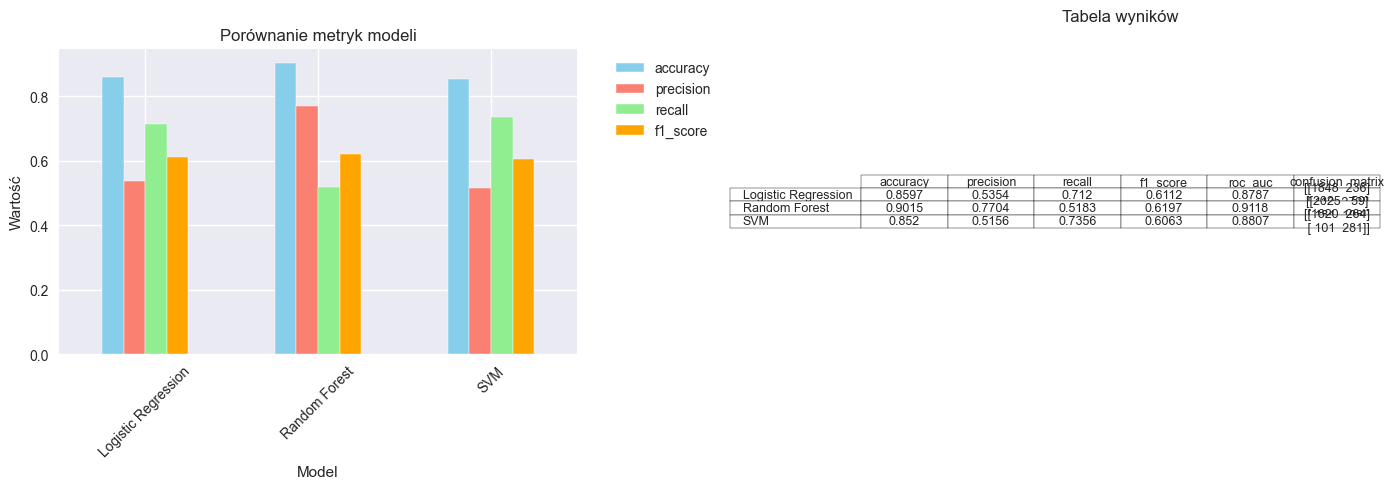

In [15]:
# Porownanie modeli
print("Porównanie modeli")
comparison = trainer.compare_models(models, X_test, y_test)
print(comparison)

# Wizualizacja porownania
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Wykres slupkowy metryk
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score']
comparison[metrics_to_plot].plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon', 'lightgreen', 'orange'])
axes[0].set_title('Porównanie metryk modeli')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Wartość')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].tick_params(axis='x', rotation=45)

# Tabela z wynikami
axes[1].axis('tight')
axes[1].axis('off')
table = axes[1].table(cellText=comparison.round(4).values,
                     rowLabels=comparison.index,
                     colLabels=comparison.columns,
                     cellLoc='center',
                     loc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
axes[1].set_title('Tabela wyników', pad=20)

plt.tight_layout()
plt.show()


## 10. Fine-tuning (Optymalizacja Hiperparametrów)


In [16]:
# Wybor najlepszego modelu do tuningu (na podstawie wynikow)
best_model_name = comparison['f1_score'].idxmax()
print(f"Najlepszy model przed tuningiem: {best_model_name}")
print(f"F1-score: {comparison.loc[best_model_name, 'f1_score']:.4f}")

# Inicjalizacja tunera
tuner = HyperparameterTuner()

# Optymalizacja dla Random Forest (najlepszy dla naszej bazy)
if best_model_name == 'Random Forest' or 'Random Forest' in models:
    print("\n Optymalizacja Random Forest")
    print("Uwaga: Używamy Pipeline - skalowanie odbywa się automatycznie w każdym foldzie")
    rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
    
    # Parametry muszą uzywac prefiksu 'model__' dla skladni Pipeline
    param_grid_rf = {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [10, 20, 30, None],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    }
    
    # Przekazujemy surowe dane (przed skalowaniem) - Pipeline zajmie się skalowaniem
    # handle_imbalance=True automatycznie doda class_weight='balanced' dla niezbalansowanych klas
    best_rf = tuner.grid_search(
        rf_base,
        param_grid_rf,
        X_train, y_train,  # Surowe dane - Pipeline zastosuje skalowanie
        cv=5,
        scoring='f1',  # F1-score jest lepsze dla niezbalansowanych klas niż accuracy
        handle_imbalance=True  # Automatyczna obsluga niezbalansowania
    )
    
    models['Random Forest (Tuned)'] = best_rf


Najlepszy model przed tuningiem: Random Forest
F1-score: 0.6197

=== Optymalizacja Random Forest ===
Uwaga: Używamy Pipeline - skalowanie odbywa się automatycznie w każdym foldzie
Dodano class_weight='balanced' do modelu w Pipeline
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Najlepsze parametry: {'model__max_depth': 30, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Najlepszy wynik CV: 0.6891


=== Porównanie przed i po tuningu ===
                 accuracy precision    recall  f1_score   roc_auc
Przed tuningiem   0.90146  0.770428  0.518325  0.619718  0.911757
Po tuningu       0.892539  0.637002  0.712042  0.672435  0.917372


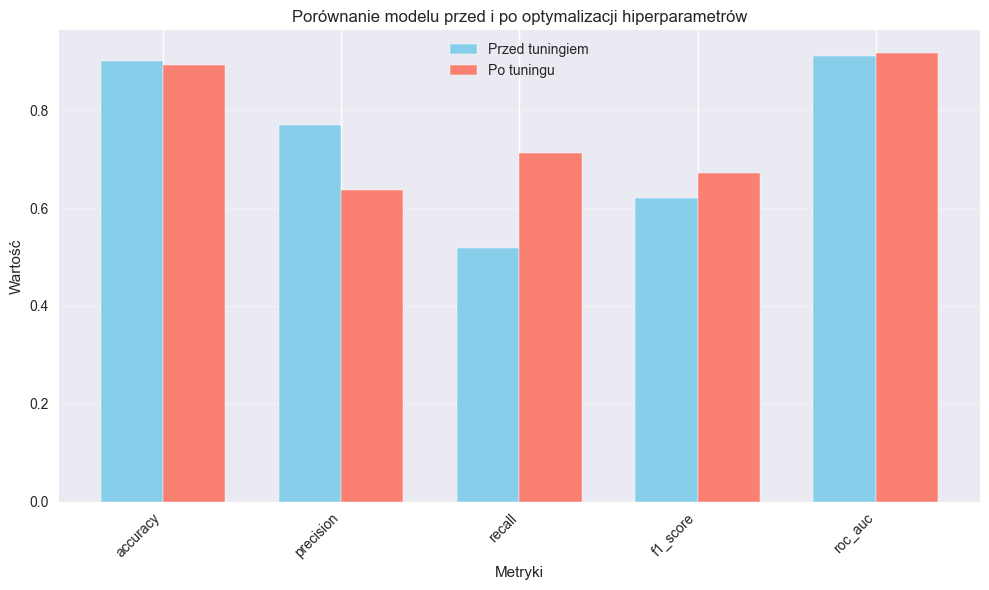

In [17]:
# Porownanie przed i po tuningu
print("Porównanie przed i po tuningu")
# Oba modele to Pipeline - automatycznie zastosują skalowanie
rf_original_metrics = trainer.evaluate_model(models['Random Forest'], X_test, y_test)
rf_tuned_metrics = trainer.evaluate_model(models['Random Forest (Tuned)'], X_test, y_test)

comparison_tuning = pd.DataFrame({
    'Przed tuningiem': rf_original_metrics,
    'Po tuningu': rf_tuned_metrics
}).T

print(comparison_tuning[['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']])

# Wizualizacja
fig, ax = plt.subplots(figsize=(10, 6))
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
x = np.arange(len(metrics))
width = 0.35

ax.bar(x - width/2, comparison_tuning.loc['Przed tuningiem', metrics], width, 
       label='Przed tuningiem', color='skyblue')
ax.bar(x + width/2, comparison_tuning.loc['Po tuningu', metrics], width, 
       label='Po tuningu', color='salmon')

ax.set_xlabel('Metryki')
ax.set_ylabel('Wartość')
ax.set_title('Porównanie modelu przed i po optymalizacji hiperparametrów')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## 11. Ewaluacja - Szczegółowa Analiza Najlepszego Modelu


=== Szczegółowe metryki najlepszego modelu ===
Accuracy: 0.8925
Precision: 0.6370
Recall: 0.7120
F1-score: 0.6724
ROC-AUC: 0.9174

Confusion Matrix:
[[1929  155]
 [ 110  272]]


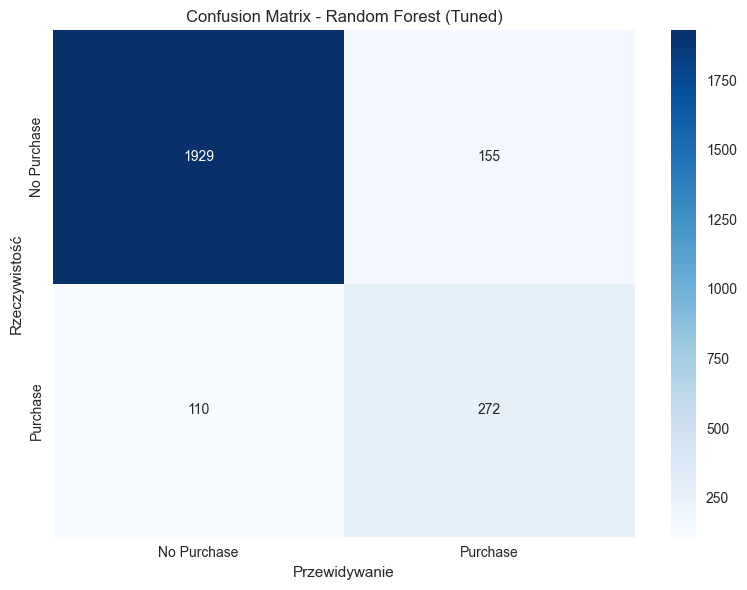


=== Classification Report ===
              precision    recall  f1-score   support

 No Purchase       0.95      0.93      0.94      2084
    Purchase       0.64      0.71      0.67       382

    accuracy                           0.89      2466
   macro avg       0.79      0.82      0.80      2466
weighted avg       0.90      0.89      0.89      2466



In [18]:
# Wybor najlepszego modelu (po tuningu)
final_model = models['Random Forest (Tuned)']  # To jest Pipeline
# Pipeline automatycznie zastosuje skalowanie podczas predict
final_metrics = trainer.evaluate_model(final_model, X_test, y_test)

print(" Szczegółowe metryki najlepszego modelu")
print(f"Accuracy: {final_metrics['accuracy']:.4f}")
print(f"Precision: {final_metrics['precision']:.4f}")
print(f"Recall: {final_metrics['recall']:.4f}")
print(f"F1-score: {final_metrics['f1_score']:.4f}")
print(f"ROC-AUC: {final_metrics['roc_auc']:.4f}")

# Confusion Matrix
cm = final_metrics['confusion_matrix']
print(f"\nConfusion Matrix:")
print(cm)

# Wizualizacja Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Purchase', 'Purchase'],
            yticklabels=['No Purchase', 'Purchase'])
plt.title('Confusion Matrix - Random Forest (Tuned)')
plt.ylabel('Rzeczywistość')
plt.xlabel('Przewidywanie')
plt.tight_layout()
plt.show()

# Classification Report
y_pred_final = final_model.predict(X_test)
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred_final, 
                          target_names=['No Purchase', 'Purchase']))


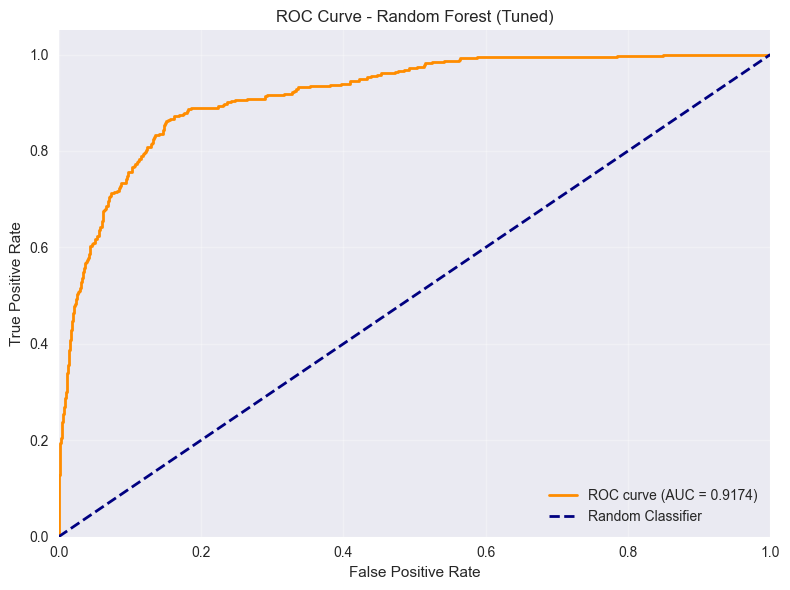

In [19]:
# ROC Curve
y_pred_proba = final_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {final_metrics["roc_auc"]:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (Tuned)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


=== Cross-Validation (5-fold) ===
F1-scores dla każdego folda: [0.7015873  0.69406393 0.7030303  0.67170953 0.6749226 ]
Średni F1-score: 0.6891 (+/- 0.0265)


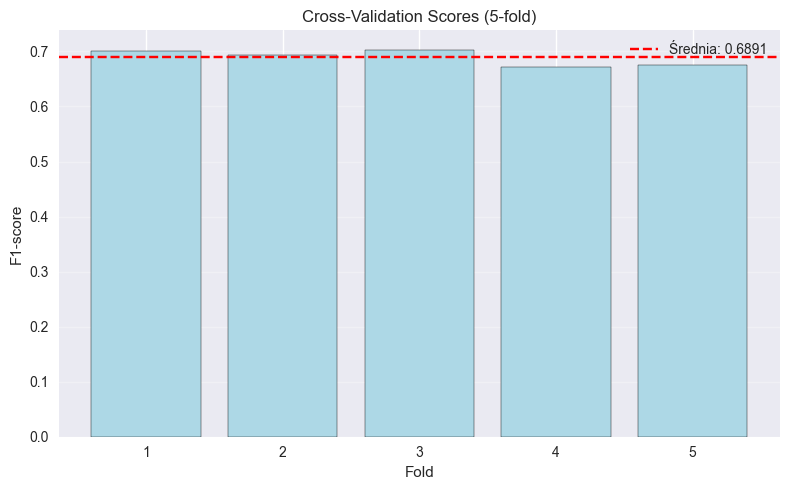

In [20]:
# Cross-validation dla ostatecznej weryfikacji
print("Cross-Validation (5-fold)")
# Pipeline automatycznie zastosuje skalowanie w kazdym foldzie
cv_scores = cross_val_score(final_model, X_train, y_train, cv=5, scoring='f1')
print(f"F1-scores dla każdego folda: {cv_scores}")
print(f"Średni F1-score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Wizualizacja CV scores
plt.figure(figsize=(8, 5))
plt.bar(range(1, 6), cv_scores, color='lightblue', edgecolor='black')
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--', 
           label=f'Średnia: {cv_scores.mean():.4f}')
plt.xlabel('Fold')
plt.ylabel('F1-score')
plt.title('Cross-Validation Scores (5-fold)')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
